# Lab 2 - Amazon Stock Price Prediction

### Instruction
1. Try at least 3 different ML algorithms (e.g. linear regression, decision tree, random forest, etc.).
2. Do hyperparameter tuning for **each** algorithm.
3. Do some very basic feature selection, and repeat the above steps with these reduced sets of features.
4. Identify the top 3 best models and note these down for later.
6. Choose the **final** "best" model that you would deploy or use on future data, stage it (in MLFlow), and run it on the test set to get a final measure of performance. Don't forget to log the test set metric.
7. Be sure you logged the exact training, validation, and testing datasets for the 3 best models, as well as hyperparameter values, and the values of your metrics.  
8. Push your code to Github. No need to track the mlruns folder, the images folder, any datasets, or the sqlite database in git.

In [1]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mlflow.models.signature import infer_signature
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="_distutils_hack")
warnings.filterwarnings("ignore", category=UserWarning, module="setuptools")


In [3]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('Amazon_stock_analysis')

<Experiment: artifact_location='/Users/zoe/Desktop/SpringII/mlops_lab/notebooks/mlruns/4', creation_time=1742535697738, experiment_id='4', last_update_time=1742535697738, lifecycle_stage='active', name='Amazon_stock_analysis', tags={}>

## Data Cleaning

In [4]:
data = pd.read_csv('../data/Amazon_stock_data_2000_2025.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.head()

/var/folders/3s/qd33d245233cg7w4zh7sbbfm0000gn/T/ipykernel_51360/1035344584.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['date'] = pd.to_datetime(data['date'])


,open,high,low,close,adj_close,volume
date,,,,,,
2000-01-03 00:00:00-05:00,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
2000-01-04 00:00:00-05:00,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2000-01-05 00:00:00-05:00,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
2000-01-06 00:00:00-05:00,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
2000-01-07 00:00:00-05:00,3.350000,3.525000,3.309375,3.478125,3.478125,210108000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6321 entries, 2000-01-03 00:00:00-05:00 to 2025-02-19 00:00:00-05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       6321 non-null   float64
 1   high       6321 non-null   float64
 2   low        6321 non-null   float64
 3   close      6321 non-null   float64
 4   adj_close  6321 non-null   float64
 5   volume     6321 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 345.7+ KB


In [6]:
data.isnull().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

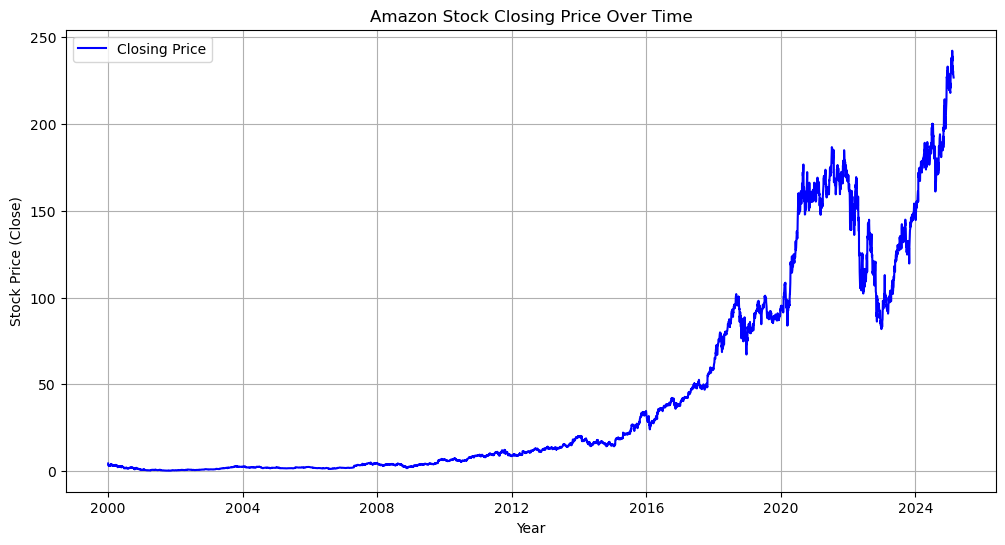

In [7]:
# Plot stock closing price over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label="Closing Price", color='blue')
plt.xlabel("Year")
plt.ylabel("Stock Price (Close)")
plt.title("Amazon Stock Closing Price Over Time")
plt.legend()
plt.grid(True)
plt.show()

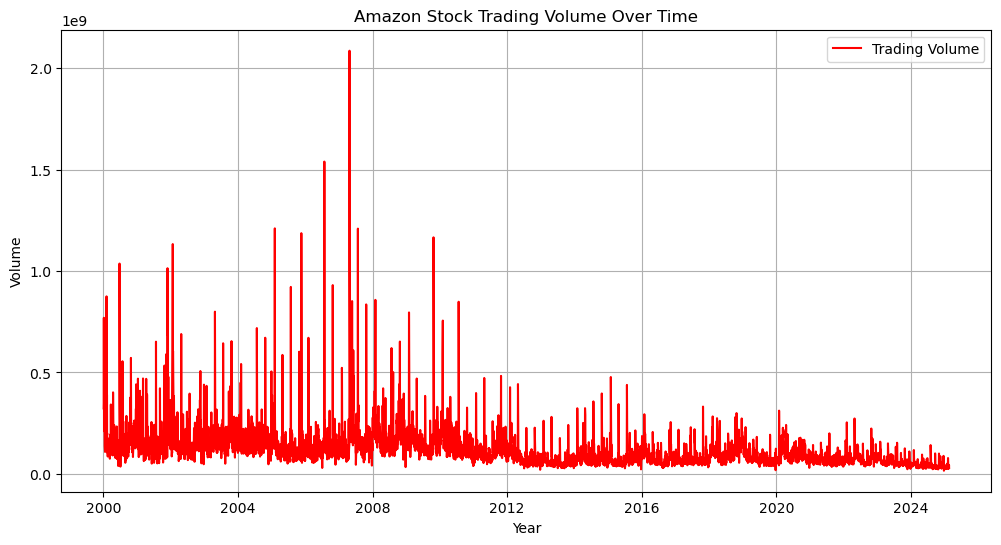

In [8]:
# Plot stock volume over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['volume'], label="Trading Volume", color='red')
plt.xlabel("Year")
plt.ylabel("Volume")
plt.title("Amazon Stock Trading Volume Over Time")
plt.legend()
plt.grid(True)
plt.show()

## Classify price movement

In [9]:
# Create binary classification target (1 = Price Up, 0 = Price Down)
data["price_movement"] = (data["close"].shift(-1) > data["close"]).astype(int)

# Feature Engineering
data["price_change"] = data["close"] - data["open"]
data["diff"] = data["high"] - data["low"]
data["close_7_avg"] = data["close"].rolling(window=7).mean()
data["close_14_avg"] = data["close"].rolling(window=14).mean()

# Drop all null values
data.dropna(inplace=True)


In [10]:
data.head()

,open,high,low,close,adj_close,volume,price_movement,price_change,diff,close_7_avg,close_14_avg
date,,,,,,,,,,,
2000-01-21 00:00:00-05:00,3.231250,3.23125,3.00000,3.103125,3.103125,229238000,1,-0.128125,0.23125,3.225000,3.441518
2000-01-24 00:00:00-05:00,3.378125,3.66875,3.37500,3.506250,3.506250,583404000,0,0.128125,0.29375,3.271875,3.372768
2000-01-25 00:00:00-05:00,3.500000,3.56250,3.30000,3.462500,3.462500,188682000,0,-0.037500,0.26250,3.295536,3.327455
2000-01-26 00:00:00-05:00,3.431250,3.50000,3.23750,3.240625,3.240625,131160000,1,-0.190625,0.26250,3.299554,3.309821
2000-01-27 00:00:00-05:00,3.259375,3.38750,3.23125,3.346875,3.346875,135680000,0,0.087500,0.15625,3.319643,3.314732


In [11]:
# Define features and target
X = data[["open", "high", "low", "close", "adj_close", "volume", "price_change", "diff", "close_7_avg", "close_14_avg"]]
y = data["price_movement"]

## Train_ test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

In [13]:
with mlflow.start_run():
    
    # Train Logistic Regression Model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Make Predictions
    y_pred = model.predict(X_test)

    # Evaluate Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Log Parameters
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("features", ", ".join(X_train.columns))

    # Log Metrics
    mlflow.log_metric("accuracy", accuracy)

    # Log Model
    mlflow.sklearn.log_model(model, "logistic_regression_model")
mlflow.end_run()


2025/03/21 10:20:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [14]:
# Hyperparameter Tunning

best_logistic_model = None
best_c = None
best_logistic_accuracy = 0

C_val = [0.001, 0.01, 0.1, 1, 10, 100]

for c in C_val:
    with mlflow.start_run():
    
        # Train Logistic Regression Model
        model = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
        model.fit(X_train, y_train)
        
        # Make Predictions
        y_pred = model.predict(X_test)

        # Evaluate Accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Log Parameters
        mlflow.log_param("model_type", "Logistic Regression")
        mlflow.log_param("C", c)
        mlflow.log_param("features", ", ".join(X_train.columns))

        # Log Metrics
        mlflow.log_metric("accuracy", accuracy)
        
        # Log Model with signature
        input_example = X_test.iloc[:5]
        signature = infer_signature(input_example, model.predict(input_example))

        # Log Model
        mlflow.sklearn.log_model(
            sk_model=model, 
            artifact_path="logistic_regression_model", 
            input_example=input_example,
            signature=signature
        )
        
        if accuracy > best_logistic_accuracy:
            best_logistic_accuracy = accuracy
            best_logistic_model = model
            best_C = c
            
    mlflow.end_run()

print(f"\nBest C: {best_C} with Accuracy: {best_logistic_accuracy:.4f}")

/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mis


Best C: 0.001 with Accuracy: 0.5071


## XGBoost

In [15]:
best_xgb_model = None
best_xgb_accuracy = 0
best_xgb_params = {}

# Define hyperparameter grid
xgb_param_grid = {
    "max_depth": [3, 5, 10],
    "learning_rate": [0.01, 0.1, 0.2]
}

# Iterate over hyperparameters
for max_depth in xgb_param_grid["max_depth"]:
    for learning_rate in xgb_param_grid["learning_rate"]:
        with mlflow.start_run():
            
            # Train XGBoost model
            xgb_model = xgb.XGBClassifier(
                max_depth=max_depth,
                learning_rate=learning_rate,
                use_label_encoder=False,
                eval_metric="logloss"
            )
            xgb_model.fit(X_train, y_train)

            # Predict and evaluate
            y_pred = xgb_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            # Log parameters and metrics
            mlflow.log_param("model_type", "XGBoost")
            mlflow.log_param("max_depth", max_depth)
            mlflow.log_param("learning_rate", learning_rate)
            mlflow.log_param("features", ", ".join(X_train.columns))
            mlflow.log_metric("accuracy", accuracy)

            # Log model with signature
            input_example = X_test.iloc[:5]
            signature = infer_signature(input_example, xgb_model.predict(input_example))

            mlflow.xgboost.log_model(
                xgb_model,
                artifact_path="xgboost_model",
                input_example=input_example,
                signature=signature
            )

            # Track best model
            if accuracy > best_xgb_accuracy:
                best_xgb_accuracy = accuracy
                best_xgb_model = xgb_model
                best_xgb_params = {"max_depth": max_depth, "learning_rate": learning_rate}
        mlflow.end_run()

print(
    f"Best XGBoost Model: max_depth={best_xgb_params['max_depth']}, learning_rate={best_xgb_params['learning_rate']}, Accuracy: {best_xgb_accuracy:.4f}"
    )

/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
 

Best XGBoost Model: max_depth=10, learning_rate=0.01, Accuracy: 0.5190


## Random Forest

In [16]:
best_rf_model = None
best_rf_accuracy = 0
best_rf_params = {}

# Define hyperparameter grid
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10]
}

# Iterate over hyperparameters
for n_estimators in rf_param_grid["n_estimators"]:
    for max_depth in rf_param_grid["max_depth"]:
        with mlflow.start_run():
            
            # Train Random Forest model
            rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
            rf_model.fit(X_train, y_train)

            # Predict and evaluate
            y_pred = rf_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            # Log parameters and metrics
            mlflow.log_param("model_type", "Random Forest")
            mlflow.log_param("n_estimators", n_estimators)
            mlflow.log_param("max_depth", max_depth)
            mlflow.log_param("features", ", ".join(X_train.columns))
            mlflow.log_metric("accuracy", accuracy)

            # Log model with signature
            input_example = X_test.iloc[:5]
            signature = infer_signature(input_example, rf_model.predict(input_example))

            mlflow.sklearn.log_model(
                sk_model=rf_model,
                artifact_path="random_forest_model",
                input_example=input_example,
                signature=signature
            )

            # Track best model
            if accuracy > best_rf_accuracy:
                best_rf_accuracy = accuracy
                best_rf_model = rf_model
                best_rf_params = {"n_estimators": n_estimators, "max_depth": max_depth}
        mlflow.end_run()
print(
    f"Best Random Forest Model: n_estimators={best_rf_params['n_estimators']}, max_depth={best_rf_params['max_depth']}, Accuracy: {best_rf_accuracy:.4f}"
    )

/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mis

Best Random Forest Model: n_estimators=50, max_depth=3, Accuracy: 0.5127


## Feature Importance

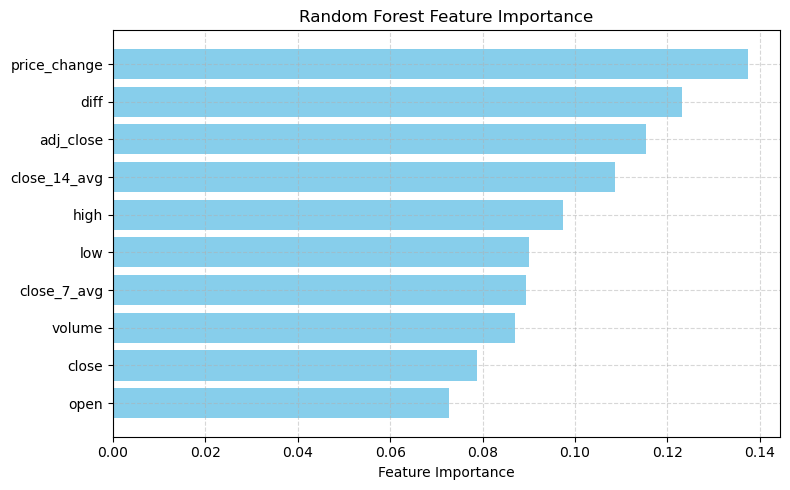

In [17]:
# Extract feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis() 
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [18]:
# Keep only the most important features
selected_features = ["price_change", "diff", "adj_close", "close_14_avg"]

# Update X_train and X_test
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


## Retrain all the models
### Logistic Regression

In [19]:
# Hyperparameter Tunning

best_logistic_model_selected = None
best_c = None
best_logistic_accuracy = 0

C_val = [0.001, 0.01, 0.1, 1, 10, 100]

for c in C_val:
    with mlflow.start_run():
    
        # Train Logistic Regression Model
        model = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
        model.fit(X_train_selected, y_train)
        
        # Make Predictions
        y_pred = model.predict(X_test_selected)

        # Evaluate Accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Log Parameters
        mlflow.log_param("model_type", "Logistic Regression")
        mlflow.log_param("C", c)
        mlflow.log_param("features", ", ".join(X_train_selected.columns))

        # Log Metrics
        mlflow.log_metric("accuracy", accuracy)
        
        # Log Model with signature
        input_example = X_test_selected.iloc[:5]
        signature = infer_signature(input_example, model.predict(input_example))

        # Log Model
        mlflow.sklearn.log_model(
            sk_model=model, 
            artifact_path="logistic_regression_model", 
            input_example=input_example,
            signature=signature
        )
        
        if accuracy > best_logistic_accuracy:
            best_logistic_accuracy = accuracy
            best_logistic_model_selected = model
            best_C = c
    mlflow.end_run()

print(f"\nBest C: {best_C} with Accuracy: {best_logistic_accuracy:.4f}")


Best C: 0.001 with Accuracy: 0.5190


### XGBoost

In [20]:
best_xgb_model_selected = None
best_xgb_accuracy = 0
best_xgb_params = {}

# Define hyperparameter grid
xgb_param_grid = {
    "max_depth": [3, 5, 10],
    "learning_rate": [0.01, 0.1, 0.2]
}

# Iterate over hyperparameters
for max_depth in xgb_param_grid["max_depth"]:
    for learning_rate in xgb_param_grid["learning_rate"]:
        with mlflow.start_run():
            
            # Train XGBoost model
            xgb_model = xgb.XGBClassifier(
                max_depth=max_depth,
                learning_rate=learning_rate,
                use_label_encoder=False,
                eval_metric="logloss"
            )
            xgb_model.fit(X_train_selected, y_train)

            # Predict and evaluate
            y_pred = xgb_model.predict(X_test_selected)
            accuracy = accuracy_score(y_test, y_pred)

            # Log parameters and metrics
            mlflow.log_param("model_type", "XGBoost")
            mlflow.log_param("max_depth", max_depth)
            mlflow.log_param("learning_rate", learning_rate)
            mlflow.log_param("features", ", ".join(X_train_selected.columns))
            mlflow.log_metric("accuracy", accuracy)

            # Log model with signature
            input_example = X_test_selected.iloc[:5]
            signature = infer_signature(input_example, xgb_model.predict(input_example))

            mlflow.xgboost.log_model(
                xgb_model,
                artifact_path="xgboost_model",
                input_example=input_example,
                signature=signature
            )

            # Track best model
            if accuracy > best_xgb_accuracy:
                best_xgb_accuracy = accuracy
                best_xgb_model_selected = xgb_model
                best_xgb_params = {"max_depth": max_depth, "learning_rate": learning_rate}

        mlflow.end_run()
print(
    f"Best XGBoost Model: max_depth={best_xgb_params['max_depth']}, learning_rate={best_xgb_params['learning_rate']}, Accuracy: {best_xgb_accuracy:.4f}"
    )

/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:57] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:58] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:137

Best XGBoost Model: max_depth=3, learning_rate=0.01, Accuracy: 0.5174


### Random Forest

In [21]:
best_rf_model_selected = None
best_rf_accuracy = 0
best_rf_params = {}

# Define hyperparameter grid
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10]
}

# Iterate over hyperparameters
for n_estimators in rf_param_grid["n_estimators"]:
    for max_depth in rf_param_grid["max_depth"]:
        with mlflow.start_run():
            
            # Train Random Forest model
            rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
            rf_model.fit(X_train_selected, y_train)

            # Predict and evaluate
            y_pred = rf_model.predict(X_test_selected)
            accuracy = accuracy_score(y_test, y_pred)

            # Log parameters and metrics
            mlflow.log_param("model_type", "Random Forest")
            mlflow.log_param("n_estimators", n_estimators)
            mlflow.log_param("max_depth", max_depth)
            mlflow.log_param("features", ", ".join(X_train_selected.columns))
            mlflow.log_metric("accuracy", accuracy)

            # Log model with signature
            input_example = X_test_selected.iloc[:5]
            signature = infer_signature(input_example, rf_model.predict(input_example))

            mlflow.sklearn.log_model(
                sk_model=rf_model,
                artifact_path="random_forest_model",
                input_example=input_example,
                signature=signature
            )

            # Track best model
            if accuracy > best_rf_accuracy:
                best_rf_accuracy = accuracy
                best_rf_model_selected = rf_model
                best_rf_params = {"n_estimators": n_estimators, "max_depth": max_depth}
        mlflow.end_run()
print(
    f"Best Random Forest Model: n_estimators={best_rf_params['n_estimators']}, max_depth={best_rf_params['max_depth']}, Accuracy: {best_rf_accuracy:.4f}"
    )

Best Random Forest Model: n_estimators=200, max_depth=3, Accuracy: 0.5127


## Find the best 3 models in MLflow

In [ ]:
# Get all runs from the MLflow experiment
experiment = mlflow.get_experiment_by_name("Amazon_stock_analysis")  
experiment_id = experiment.experiment_id

# Get the runs as a DataFrame
model_runs = mlflow.search_runs(experiment_ids=[experiment_id])

# Select relevant columns
model_runs = model_runs[["run_id", "params.model_type", "params.features", "params.C", "params.max_depth", "params.learning_rate", "metrics.accuracy"]]

# Sort by accuracy in descending order
model_runs = model_runs.sort_values(by="metrics.accuracy", ascending=False)

model_runs[:3]

,run_id,params.model_type,params.features,params.C,params.max_depth,params.learning_rate,metrics.accuracy
23,6e004c1a6b6d4543b93c02faa0465b62,Logistic Regression,"price_change, diff, adj_close, close_14_avg",0.001,None,None,0.519017
35,5bfa2fbb66754d449adfbf715d9e80cc,XGBoost,"open, high, low, close, adj_close, volume, pri...",None,10,0.01,0.519017
17,4d2666e52f574203b418d8d97d8acbe6,XGBoost,"price_change, diff, adj_close, close_14_avg",None,3,0.01,0.517433


According to MLflow, the top 3 models were:
- Logistic Regression (C=0.001) with reduced X_train
- XGBoost (max_depth=10, learning_rate=0.01) with X_train
- XGBoost (max_depth=3, learning_rate=0.01) witj reduced_X_train

The accuracy schore also showed that the the two model has the same accuracy score. The top 1 use reduced features, but the second best model used all features. So I will choose the top model as the best model to use on future data

## Load the best model

In [27]:
# Use the first model as the best run
logged_model_uri = 'runs:/6e004c1a6b6d4543b93c02faa0465b62/logistic_regression_model'
best_model = mlflow.sklearn.load_model(logged_model_uri)

In [ ]:
# Make prediction on the best model
y_pred = best_model.predict(X_test_selected)
final_acc = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {final_acc:.4f}")

Test accuracy: 0.5190


In [29]:
y_pred[:5]

array([0, 1, 1, 1, 1])